1. 2d rgbÏóêÏÑú yolo ÏßÑÌñâ
2. DepthÏóê yoloÏóêÏÑú ÏñªÏùÄ ROI Ï†ÅÏö©
3. Camera intrinsic Load
4. ROI depth -> 3d PCD ÏßÑÌñâ 
5. 3d ROI PCDÎ°úÎ∂ÄÌÑ∞ Í∞Å ÌîΩÏÖÄÏóê ÎåÄÌïú Surface normal ÏàòÌñâ 
6. PCA ÏàòÌñâÌïòÏó¨ Ï£ºÏöî Ï∂ï Ï∂îÏ∂ú
7. Î≤ïÏÑ†Í≥º PCAÏ∂ïÏùÑ ÌÜµÌï¥ Ï¢åÌëúÍ≥Ñ Íµ¨ÏÑ±
8. ÌöåÏ†ÑÌñâÎ†¨ÏùÑ ÌÜµÌï¥ RPYÎ≥ÄÌôò

Ïù¥ depth mapÏùÄ Îã®ÏúÑ: mm, **ÌòïÏãù: 16-bit Ï†ïÏàòÌòï (uint16)**ÏûÖÎãàÎã§.

Í∞íÏù¥ 327 ~ 1513 ÏÇ¨Ïù¥Ïù∏ Í≤ÉÏúºÎ°ú Î≥¥ÏïÑ, ÏïΩ 0.3 ~ 1.5ÎØ∏ÌÑ∞ Î≤îÏúÑÏùò Í±∞Î¶¨ Îç∞Ïù¥ÌÑ∞Í∞Ä Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏñ¥Ïöî.

Ï¶â, Open3DÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî depth_scale=1000.0 ÏÑ§Ï†ïÏù¥ Ï†ïÌôïÌûà ÎßûÏäµÎãàÎã§.



In [2]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from ultralytics import YOLO
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [95]:
mc.get_coords()

[49.5, -64.6, 410.5, -90.26, 0.26, -90.0]

In [103]:
# image Ï∫°Ï≤ò 
import pyrealsense2 as rs
from datetime import datetime
    
def capture_d455_images(save_dir="/home/ros/llm_robot/data/captures",
                        rgb_size=(848,480), depth_size=(848,480),
                        depth_preset=rs.rs400_visual_preset.high_density):

    """
    ‚Ä¢ RealSense D455ÏóêÏÑú RGB + DepthÎ•º ÎèôÏãúÏóê Ï∫°Ï≤òÌï¥ Ï†ÄÏû•
    ‚Ä¢ save_dir        : Ï†ÄÏû• Ìè¥Îçî (ÏóÜÏúºÎ©¥ ÏûêÎèô ÏÉùÏÑ±)
    ‚Ä¢ rgb_size        : (w, h)  Ïòà) (1280, 720)
    ‚Ä¢ depth_size      : (w, h)  Ïòà) (848, 480)
    ‚Ä¢ depth_preset    : rs.rs400_visual_preset.*  (Í∏∞Î≥∏ High-Accuracy)
    Î∞òÌôòÍ∞í: (color_path, depth_path)
    """
        
    os.makedirs(save_dir, exist_ok=True)

    # ÎÇ†Ïßú Í∏∞Î∞ò ÌååÏùºÎ™Ö ÏÉùÏÑ±
    stamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    color_path = os.path.join(save_dir, f"{stamp}_color.jpg")
    depth_path = os.path.join(save_dir, f"{stamp}_depth.npy")

    # RealSense ÌååÏù¥ÌîÑÎùºÏù∏ ÏÑ§Ï†ï
    pipe, cfg = rs.pipeline(), rs.config()

    cfg.enable_stream(rs.stream.color,  *rgb_size,   rs.format.bgr8, 30)
    cfg.enable_stream(rs.stream.depth,  *depth_size, rs.format.z16,  30)
    profile = pipe.start(cfg)
    
    # intelÏóêÏÑú ÎØ∏Î¶¨ ÏÑ§Ï†ïÌï¥Îëî ÌîÑÎ¶¨ÏÖãÏù∏ 'High Accuracy' Ï†ÅÏö©
    depth_sensor = profile.get_device().first_depth_sensor()
    if depth_sensor.supports(rs.option.visual_preset):
        depth_sensor.set_option(rs.option.visual_preset, depth_preset)
    
    # Depthmap Ï†ïÎ†¨
    frames = rs.align(rs.stream.color).process(pipe.wait_for_frames())
    depth, color = frames.get_depth_frame(), frames.get_color_frame()
    if not depth or not color:
        pipe.stop()
        raise RuntimeError("Failed to capture frames")    
    
    # Ï†ÄÏû• (RGB = JPEG, Depth = NPY)
    color_img = np.asanyarray(color.get_data())            # uint8 (BGR)
    depth_raw = np.asanyarray(depth.get_data())            # uint16 (mm / depth_scale)

    cv2.imwrite(color_path, color_img, [cv2.IMWRITE_JPEG_QUALITY, 95])
    np.save(depth_path, depth_raw)

    pipe.stop()
    
    return color_path, depth_path    


### 1. 2D RGBÏóêÏÑú YOLO ÏàòÌñâÌïòÏó¨ ROI Í∞ÄÏ†∏Ïò§Í∏∞

In [4]:
MAIN_PATH = "/home/ros/llm_robot/"
MODEL_DIR = MAIN_PATH + "yolo11_seg_cube_best.pt"

model = YOLO(MODEL_DIR)

In [105]:
color_path, depth_path = capture_d455_images()

# color_path = "/home/ros/llm_robot/data/captures/2025-07-21_21-09-27_color.jpg"
# depth_path = "/home/ros/llm_robot/data/captures/2025-07-21_21-09-27_depth.npy"

img = cv2.imread(color_path)

result = model(img)


0: 384x640 1 cube, 23.8ms
Speed: 21.5ms preprocess, 23.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


In [106]:
result[0].show()

In [107]:
# yolo Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄ
yolo_img = result[0]

# bbox Ï∂îÏ∂ú (yolo ÏàòÌñâ Ïãú pytorch tensor ÌòïÏãùÏù¥ GPU ÏÉÅÏóê Ïò¨ÎùºÍ∞Ä ÏûàÎäî Í≤ΩÏö∞Í∞Ä ÎßéÍ∏∞ ÎïåÎ¨∏Ïóê, cpuÎ°ú ÏòÆÍ≤®Ï§å.)
boxes = yolo_img.boxes[0].xyxy.cpu().numpy().astype(int)  

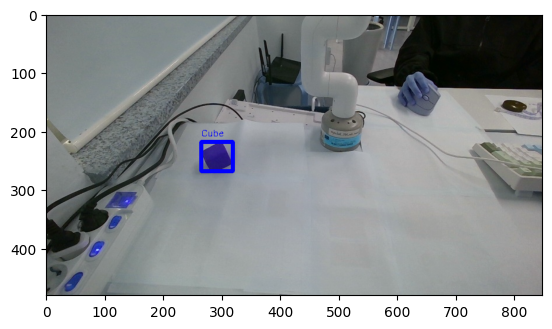

In [108]:
for i, (x1, y1, x2, y2) in enumerate(boxes):
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 5)
    cv2.putText(img, f'Cube', (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
plt.imshow(img);

In [109]:
x1, y1, x2, y2 = boxes[0]
print(x1, y1, x2, y2)

265 218 319 268


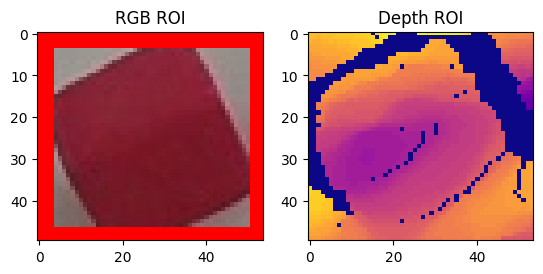

In [110]:
# RGBÏôÄ Depth Îëò Îã§ cropÌï¥ÏÑú ÏãúÍ∞ÅÌôî ÎπÑÍµê
depth = np.load(depth_path)
roi_rgb = img[y1:y2, x1:x2] 
roi_depth = depth[y1:y2, x1:x2]
# roi_depth = np.nan_to_num(roi_depth, nan=0.0)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(roi_rgb, cv2.COLOR_BGR2RGB))
plt.title("RGB ROI")

plt.subplot(1, 2, 2)
plt.imshow(roi_depth*1000,cmap="plasma")
plt.title("Depth ROI")
plt.show()


In [111]:
print("RGB shape:", img.shape)     # Ïòà: (480, 640, 3)
print("Depth shape:", depth.shape) # Ïòà: (480, 640)


RGB shape: (480, 848, 3)
Depth shape: (480, 848)


## 3. camera intrinsic load

In [112]:
# camera_intrinsic Î∂àÎü¨Ïò§Í∏∞
INTR_DIR = MAIN_PATH + "data/Calibration/d455_intrinsics.yaml"

fs = cv2.FileStorage(INTR_DIR, cv2.FILE_STORAGE_READ)
camera_matrix = fs.getNode("camera_matrix").mat()
dist_coeffs = fs.getNode("dist_coeffs").mat()       # RGB ÏôúÍ≥° Î≥¥Ï†ïÏö©
fs.release()

print(camera_matrix)
print(dist_coeffs)

[[     425.95           0      427.19]
 [          0      425.37         246]
 [          0           0           1]]
[[  -0.055946    0.068781 -0.00011233  0.00074334   -0.022006]]


In [113]:
fx = camera_matrix[0][0]    # ÏàòÌèâ Ï¥àÏ†ê Í±∞Î¶¨
fy = camera_matrix[1][1]    # ÏàòÏßÅ Ï¥àÏ†ê Í±∞Î¶¨
ppx = camera_matrix[0][2]    # center x
ppy = camera_matrix[1][2]    # center y

print(fx, fy, ppx, ppy)

425.9524841308594 425.373291015625 427.1853942871094 245.99588012695312


In [114]:
depth.shape[1], depth.shape[0]

(848, 480)

In [115]:
roi_ppx = ppx - x1
roi_ppy = ppy - y1

intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=depth.shape[1],
    height=depth.shape[0],
    fx=fx,
    fy=fy,
    cx=ppx,
    cy=ppy
)

roi_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=roi_depth.shape[1],
    height=roi_depth.shape[0],
    fx=fx,
    fy=fy,
    cx=roi_ppx,
    cy=roi_ppy
)

## 4. ROI Depth -> PointCloud

In [116]:
fx, fy, ppx, ppy 

(425.9524841308594, 425.373291015625, 427.1853942871094, 245.99588012695312)

In [117]:
depth_contig = np.ascontiguousarray(roi_depth)
depth_o3d = o3d.geometry.Image(depth_contig)

# depth_o3d = o3d.geometry.Image(roi_depth)

dummy_gray = np.ones_like(roi_depth, dtype=np.uint8) * 128
dummy_rgb = np.stack([dummy_gray]*3, axis=2) 
dummy_color = o3d.geometry.Image(dummy_rgb)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    dummy_color,
    depth_o3d,
    depth_scale=1000,
    depth_trunc = 2.0,
    convert_rgb_to_intensity = False
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd,
    roi_intrinsic
)

# Ï¢åÌëúÍ≥Ñ ÎßûÏ∂§ (Open3D ÏãúÍ∞ÅÌôî Í∏∞Ï§Ä)
pcd.transform([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 0],
               [0, 0, 0, 1]])

# ÏãúÍ∞ÅÌôî
o3d.visualization.draw_geometries([pcd])


# 5. Í∞Å Ìè¨Ïù∏Ìä∏Ïóê ÎåÄÌï¥ Surface Normal Ï∂îÏ†ï

In [118]:
# 3d ROI PCDÎ°úÎ∂ÄÌÑ∞ Í∞Å ÌîΩÏÖÄÏóê ÎåÄÌïú Surface normal ÏàòÌñâ
pcd.estimate_normals(search_param = o3d.geometry.KDTreeSearchParamKNN(knn=30))
pcd.normalize_normals()

PointCloud with 2161 points.

In [119]:
o3d.visualization.draw_geometries(
    [pcd],
    window_name="Step 3: PCD + Surface Normals",
    point_show_normal=True
)

# 6. PCA ÏßÑÌñâÌïòÏó¨ Ï£ºÏöî Ï∂ï Ï∂îÏ∂ú

In [120]:
# 3d Ï¢åÌëú Í∏∞Ï§Ä PCA ÏàòÌñâ
points = np.asarray(pcd.points)
center_xyz = np.mean(points, axis=0)
cam_xyz2 = center_xyz.tolist()

# Í∞Å Ìè¨Ïù∏Ìä∏ÏóêÏÑú Ï§ëÏã¨ Ï¢åÌëúÎ•º ÎπºÏÑú ÏõêÏ†êÏúºÎ°ú Ïû¨Î∞∞Ïπò
points_centered = points - center_xyz

# Í≥µÎ∂ÑÏÇ∞ÌñâÎ†¨ Í≥ÑÏÇ∞
cov = np.cov(points_centered.T)

# eig_vals: Í∞Å Ï∂ï Î∞©Ìñ•Ïùò Î∂ÑÏÇ∞ ÌÅ¨Í∏∞ (PCAÏùò ÏÑ∏ Í∞úÏùò Ï£ºÏÑ±Î∂Ñ Í∞í)
# eig_vecs: Í∞Å Ïó¥Ïù¥ Í≥†Ïú†Î≤°ÌÑ∞ ‚Üí Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÇ∞ Î∞©Ìñ• Î≤°ÌÑ∞
eig_vals, eig_vecs = np.linalg.eigh(cov)

In [121]:
center_xyz

array([    -0.1598,   0.0021956,    -0.49869])

In [122]:
# --- Ï∂ï ÏãúÍ∞ÅÌôîÏö© line ÏÉùÏÑ± ---
def create_axis_line(origin, direction, color, length=0.02):
    pts = [origin, origin + direction * length]
    lines = [[0, 1]]
    ls = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(pts),
        lines=o3d.utility.Vector2iVector(lines)
    )
    ls.colors = o3d.utility.Vector3dVector([color])
    return ls

x_line = create_axis_line(center_xyz, eig_vecs[:, 0], [1, 0, 0])  # Îπ®Í∞ï
y_line = create_axis_line(center_xyz, eig_vecs[:, 1], [0, 1, 0])  # Ï¥àÎ°ù
z_line = create_axis_line(center_xyz, eig_vecs[:, 2], [0, 0, 1])  # ÌååÎûë

# --- 6. ÏãúÍ∞ÅÌôî ---
o3d.visualization.draw_plotly([pcd, x_line, y_line, z_line], window_name="PCA Axes")

In [123]:
# Í≥†Ïú†Í∞í Í∏∞Ï§Ä ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
idx = np.argsort(eig_vals)[::-1]
eig_vecs = eig_vecs[:, idx]  # ‚Üê Í∞Å Ïó¥Ïù¥ Í≥†Ïú†Î≤°ÌÑ∞ (x, y, zÏ∂ï ÏàúÏÑú)

# Ï∂ï Íµ¨ÏÑ±
x_axis = eig_vecs[:, 0]  # Í∞ÄÏû• ÌÅ∞ Î∂ÑÏÇ∞ Î∞©Ìñ• ‚Üí grasp Î∞©Ìñ•
y_axis = eig_vecs[:, 1]
z_axis = eig_vecs[:, 2]  # Í∞ÄÏû• ÏûëÏùÄ Î∂ÑÏÇ∞ Î∞©Ìñ• ‚Üí surface normal
# print(x_axis, y_axis, z_axis)

# Î≤ïÏÑ† Î∞©Ìñ•Ïù¥ ÏïÑÎûòÎ•º Í∞ÄÎ¶¨ÌÇ§Î©¥ Î∞òÏ†Ñ
if z_axis[2] < 0:
    z_axis = -z_axis
    
# ÏßÅÍµêÏÑ± ÌôïÎ≥¥ (ÌïÑÏàò!)
x_axis -= np.dot(x_axis, z_axis) * z_axis
x_axis /= np.linalg.norm(x_axis)
y_axis = np.cross(z_axis, x_axis)
print(x_axis, y_axis, z_axis)


[   -0.41374      0.4313    -0.80175] [    -0.9103    -0.20857     0.35757] [  -0.012999     0.87777      0.4789]


# 7. Î≤ïÏÑ†Í≥º PCA Ï∂ïÏúºÎ°ú Ï¢åÌëúÍ≥Ñ Íµ¨ÏÑ±

In [124]:
# 4. ÌöåÏ†ÑÌñâÎ†¨ Íµ¨ÏÑ± (Ïó¥Î≤°ÌÑ∞ Í∏∞Ï§Ä)
R_mat = np.stack([x_axis, y_axis, z_axis], axis=1)

# 5. Euler angles (RPY) Ï∂îÏ∂ú
rpy = Rotation.from_matrix(R_mat).as_euler('xyz', degrees=True)
# rpy_int = rpy.astype(int)
print(f"Roll: {rpy[0]:.2f}, Pitch: {rpy[1]:.2f}, Yaw: {rpy[2]:.2f}")

Roll: 36.75, Pitch: 53.30, Yaw: 133.81


# Ïã§Ìóò

In [30]:
import time
from pymycobot import MyCobot280

SERIAL_PORT = "/dev/ttyACM0"
BAUD_RATE = 115200

mc = MyCobot280(SERIAL_PORT, BAUD_RATE)

In [ ]:
# HAND_EYE_PATH = "/home/ros/llm_robot/data/Calibration/cam2gripper.json"

# GRIPPER_OPEN  = 100        # ÏÉÅÌô©Ïóê ÎßûÍ≤å Ï°∞Ï†ï
# GRIPPER_CLOSE =   0
# MOVE_SPEED         = 50         # 0~100
# HOVER_Z = 0.05                  # M
# DESCEND_OFFSET = 0.005

In [31]:
def detect_objects(c_path, d_path, target_list, 
                   camera_matrix, dist_coeffs,  
                   best_model = "/home/ros/llm_robot/yolo11x.pt"):
    
    depth_raw  = np.load(d_path)
    depth_scale = 0.001    # mm -> m
    
    # ‚ñ∂ intrinsics
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]
    
    model = YOLO(best_model)  
    results = model(c_path)
    
    r = results[0]          # Ìïú Ïû•Ïù¥ÎãàÍπå
    xyxy  = r.boxes.xyxy.cpu().numpy()  # [N,4]
    cls   = r.boxes.cls.cpu().numpy().astype(int)
    conf  = r.boxes.conf.cpu().numpy()
    names = r.names                     # {idx:'label'}

    outputs = []  # ÏµúÏ¢Ö (label, cx, cy, z, x_cam, y_cam, z_cam) Î¶¨Ïä§Ìä∏

    for box, c, p in zip(xyxy, cls, conf):
        label = names[c]
        if label not in target_list:        # üéØ ÏõêÌïòÎäî ÌÅ¥ÎûòÏä§Îßå ÌÜµÍ≥º
            continue

        x1, y1, x2, y2 = map(int, box)
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

        # Depth ROI ‚Üí Z (m Í∏∞Ï§Ä)
        roi_depth = depth_raw[y1:y2, x1:x2]
        valid = roi_depth[roi_depth > 0]
        if valid.size == 0:
            print(f"[WARN] {label} depth invalid, skip")
            continue
        
        # ÌèâÍ∑†ÏóêÏÑú ÏµúÏÜåÍ∞í(ÌèâÎ©¥)ÏùÑ Î∫Ä Í∞í
        # z_floor = np.percentile(valid, 95)  # Î∞îÎã• Ï∂îÏ†ï
        # z_obj   = np.percentile(valid, 30)  # Î¨ºÏ≤¥ Ï∂îÏ†ï
        # z = (z_floor - z_obj) * depth_scale 
        z = np.median(valid) * depth_scale 
        
        # ÌîΩÏÖÄ Ï¢åÌëú Î≥¥Ï†ï
        pixel = np.array([[[center_x, center_y]]], dtype=np.float32)    # (1, 1, 2)
        undistorted = cv2.undistortPoints(pixel, camera_matrix, dist_coeffs)
        cx_u, cy_u = undistorted[0][0]
        
        
        # ÌîΩÏÖÄ ‚Üí Ïπ¥Î©îÎùº XYZ 
        x_cam = (cx_u - cx) * z / fx
        y_cam = (cy_u - cy) * z / fy
        z_cam = z

        outputs.append(
            {"label": label,
            "bbox": [x1, y1, x2, y2],
            "pixel_xy": [cx, cy],
            "undistroted_xy": [float(cx_u), float(cy_u)], 
            "depth_m": z,
            "cam_xyz": [x_cam, y_cam, z_cam],
            "conf": float(p)}
        )

    print("\nüì¶ Ï∂îÏ∂úÎêú Í∞ùÏ≤¥ Ï†ïÎ≥¥")
    for obj in outputs:
        print(f"{obj['label']:10s}  z={obj['depth_m']:.3f} m  "
            f"cam=({obj['cam_xyz'][0]:.3f}, {obj['cam_xyz'][1]:.3f}, {obj['cam_xyz'][2]:.3f})")
    
    return outputs
        

In [125]:
target_list = ["cube"]
yolo_outputs = detect_objects(color_path, depth_path,target_list, 
                                  camera_matrix, dist_coeffs, MODEL_DIR)
cam_xyz = yolo_outputs[0]["cam_xyz"]


image 1/1 /home/ros/llm_robot/data/captures/2025-07-22_10-46-45_color.jpg: 384x640 1 cube, 7.7ms
Speed: 1.0ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

üì¶ Ï∂îÏ∂úÎêú Í∞ùÏ≤¥ Ï†ïÎ≥¥
cube        z=0.490 m  cam=(-0.492, -0.283, 0.490)


In [126]:
cam_xyz

[-0.49178548840538844, -0.2833780311102966, 0.49]

In [144]:
import math

def euler_to_rot(rx, ry, rz):
    rx, ry, rz = map(math.radians, [rx, ry, rz])
    
    Rx = np.array([
        [1, 0, 0],
        [0, math.cos(rx), -math.sin(rx)],
        [0, math.sin(rx), math.cos(rx)]
    ])
    Ry = np.array([
        [math.cos(ry), 0, math.sin(ry)],
        [0, 1, 0],
        [-math.sin(ry), 0, math.cos(ry)]
    ])
    Rz = np.array([
        [math.cos(rz), -math.sin(rz), 0],
        [math.sin(rz), math.cos(rz), 0],
        [0, 0, 1]
    ])
    
    return Rz @ Ry @ Rx

# ÏµúÏ¢ÖÎ≥ÄÌôò: cam_xyz->base_xyz
def cam_to_base(mc, cam_xyz, cam_rpy):
    import json, numpy as np
    from scipy.spatial.transform import Rotation

    # 1) Cam-to-Gripper Î≥¥Ï†ï Î∂àÎü¨Ïò§Í∏∞ (mm Îã®ÏúÑ Ïú†ÏßÄ)
    with open("/home/ros/llm_robot/data/Calibration/Cam-to-Gripper/cam2gripper_calibration_refined.json") as f:
        data = json.load(f)
    R_c2g = np.array(data["R_cam2gripper"])        # 3√ó3
    t_c2g = np.array(data["t_cam2gripper"]).reshape(3,1)  # mm

    # 2) Î°úÎ¥á ÌòÑÏû¨ Í∑∏Î¶¨Ìçº Ìè¨Ï¶à (Í∏∞Î≥∏ mm, deg)
    coords = mc.get_coords()       # [Xmm, Ymm, Zmm, Rx¬∞, Ry¬∞, Rz¬∞]
    t_b2g = np.array(coords[0:3]).reshape(3,1)     # mm 
    # deg‚Üírad Î≥ÄÌôò ÌõÑ ÌöåÏ†ÑÌñâÎ†¨ ÏÉùÏÑ±
    rx, ry, rz = np.deg2rad(coords[3:6])
    R_b2g = euler_to_rot(rx, ry, rz)

    # 3) Ïπ¥Î©îÎùº Ï¢åÌëú ‚Üí Í∑∏Î¶¨Ìçº Ï¢åÌëú
    p_cam = np.array(cam_xyz).reshape(3,1) *1000  # mm
    p_gripper = R_c2g @ p_cam + t_c2g       # mm

    # 4) Í∑∏Î¶¨Ìçº ‚Üí Î≤†Ïù¥Ïä§ Ï¢åÌëú
    p_base = R_b2g @ p_gripper + t_b2g      # mm
    x_mm, y_mm, z_mm = np.around(p_base.flatten(), 1)

    # 5) ÌïÑÏöî Ïãú Î≥¥Îìú Ïò§ÌîÑÏÖã Ï†ÅÏö©
    # x_mm -= 250  # ÏòàÏãú: Charuco Î≥¥Îìú Í∏∞Ï§Ä Ïò§ÌîÑÏÖã

    # 6) Ïπ¥Î©îÎùºÏóêÏÑú Ï∏°Ï†ïÌïú Ïò§Î¶¨ÏóîÌÖåÏù¥ÏÖò(cam_rpy) ‚Üí Î≤†Ïù¥Ïä§ RPY
    cam_rx, cam_ry, cam_rz = np.deg2rad(cam_rpy)
    R_cam = euler_to_rot(cam_rx, cam_ry, cam_rz)
    R_gripper = R_c2g @ R_cam
    R_base    = R_b2g @ R_gripper
    rpy_base = Rotation.from_matrix(R_base).as_euler('xyz', degrees=True)
    r_base, p_base_ang, y_base_ang = np.round(rpy_base, 1)

    # 7) Í≤∞Í≥º Î∞òÌôò [Xmm, Ymm, Zmm, R¬∞, P¬∞, Y¬∞]
    return [y_mm, x_mm, z_mm, r_base, p_base_ang, y_base_ang]

In [35]:
mc.send_angles([0,0,0,0,0,0], 30)

-1

In [73]:
cam_xyz, cam_xyz2

([-0.41899310598269873, -0.2415927877764419, 0.418],
 [0.09064894050595093, -0.062316266507022426, -0.4227093840591569])

In [149]:
gripper_length_mm = 160
base_xyz_mm = cam_to_base(mc, [0.0906, -0.0623, -0.4227], rpy)
# base_xyz_mm[2] = gripper_length_mm
base_xyz_mm[3] = -179
base_xyz_mm[4] = 0.0
base_xyz_mm

[-245.1, 359.2, 9.5, -179, 0.0, -17.0]

In [148]:
gripper_length_mm = 160
base_xyz_mm = cam_to_base(mc, cam_xyz2, rpy)
# base_xyz_mm[2] = gripper_length_mm
# base_xyz_mm[3] = -179
base_xyz_mm[4] = 0.0
base_xyz_mm

[-138.4, 257.1, -215.9, -1.0, 0.0, -17.0]

In [106]:
base_xyz_mm2 = base_xyz_mm.copy()
realx = base_xyz_mm[1] 
realy = base_xyz_mm[0]
base_xyz_mm2[0] = realx
base_xyz_mm2[1] = realy
base_xyz_mm2

[516.2, 34.0, 160, -179, 0.0, 59.0]

In [127]:
# 1. PCA
points = np.asarray(pcd.points)
center_xyz = np.mean(points, axis=0)

dists = np.linalg.norm(points - center_xyz, axis=1)
center_idx = np.argmin(dists)

cov = np.cov(points_centered.T)
_, eig_vecs = np.linalg.eigh(cov)  # Ï£ºÏ∂ï: Í∞Å Ïó¥

# 2. Surface normal (Ï§ëÏã¨Ï†ê Í∏∞Ï§Ä)
z_axis2 = np.asarray(pcd.normals)[center_idx]
z_axis2 /= np.linalg.norm(z_axis2)

# 3. PCA Ï∂ï Ï§ë zÏôÄ ÏßÅÍµêÌïú Ï£ºÏ∂ï ÏÑ†ÌÉù
for i in range(3):
    cand = eig_vecs[:, i]
    cand /= np.linalg.norm(cand)
    if abs(np.dot(cand, z_axis2)) < 0.9:  # Ï∂©Î∂ÑÌûà ÏàòÏßÅÌïòÎ©¥
        x_axis2 = cand
        break

# 4. ÎÇòÎ®∏ÏßÄ Ï∂ï
y_axis2 = np.cross(z_axis2, x_axis2)

# 5. ÌöåÏ†Ñ ÌñâÎ†¨ ‚Üí RPY
R_mat2 = np.stack([x_axis2, y_axis2, z_axis2], axis=1)
rpy2 = Rotation.from_matrix(R_mat2).as_euler('xyz', degrees=True)

# rpy_int = rpy.astype(int)

print(f"Surface Normal Í∏∞Î∞ò RPY:")
print(f"Roll: {rpy2[0]:.2f}, Pitch: {rpy2[1]:.2f}, Yaw: {rpy2[2]:.2f}")

print(x_axis2, y_axis2, z_axis2)

Surface Normal Í∏∞Î∞ò RPY:
Roll: -51.91, Pitch: -8.81, Yaw: 73.24
[  -0.012999     0.87777      0.4789] [   -0.44722     0.15504    -0.29631] [   -0.34512     0.51013     0.78782]


In [128]:
rpy, rpy2

(array([     36.746,      53.297,      133.81]),
 array([    -51.915,     -8.8148,      73.243]))

In [129]:
cam_xyz, cam_xyz2

([-0.49178548840538844, -0.2833780311102966, 0.49],
 [-0.15979864800379853, 0.002195557679762406, -0.4986853306765691])

In [131]:
gripper_length_mm = 160
base_xyz_mm = cam_to_base(mc, cam_xyz, rpy2)
# base_xyz_mm[2] = gripper_length_mm
base_xyz_mm

[-203.5, -68.1, 258.7, -1.6, -42.9, -18.4]

In [ ]:
color_path

In [163]:
send_coords = [-170, -170, 160, -179, 0, 124]
send_angles = [-105.38, 12.91, -63.63, -38.93, 1.05, -50.09]

mc.set_gripper_state(0,50)
mc.send_coords(send_coords, 40,1)
time.sleep(2)
mc.set_gripper_value(10,40)
mc.send_angles(send_angles, 50)

-1

In [164]:
init_pose = [0,0,0,0,0,0]

mc.send_coords(send_coords, 50,1)
time.sleep(1)
mc.set_gripper_state(0,50)
mc.send_angles(init_pose, 50)
mc.set_gripper_value(10,40)

-1

In [ ]:
mc.get_coords()

In [ ]:
mc.send_angles([0,0,0,0,0,0], 40)

In [ ]:
mc.release_all_servos()
input("")
mc.get_coords()